In [2]:

library(dplyr)
library(rio) #great for exporting, importing
library (stringr)
library(cowplot)
library(tidyr)
library(ggpubr)

library(readxl)
library(patchwork)
library(RColorBrewer)
library(viridis)
library(ggvenn)
library(gridExtra)

In [122]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS/LAPACK: /Users/Eva/opt/anaconda3/envs/R4b/lib/libopenblasp-r0.3.26.dylib;  LAPACK version 3.12.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/New_York
tzcode source: system (macOS)

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] gridExtra_2.3      ggvenn_0.1.10      viridis_0.6.4      viridisLite_0.4.2 
 [5] RColorBrewer_1.1-3 patchwork_1.1.2    readxl_1.4.3       ggpubr_0.6.0      
 [9] ggplot2_3.5.0      tidyr_1.3.1        cowplot_1.1.1      stringr_1.5.1     
[13] rio_1.0.1          dplyr_1.1.4       

loaded via a namespace (and not attached):
 [1] utf8_1.2.4        generics_0.1.3    rstatix_0.7.2     stringi_1.8.3    
 [5] digest_0.6.35     magrittr_2.0.3    evaluate_0.23     pbdZMQ_0.3-11    
 [

In [2]:
# IMPORT EXPRESSED GENE DATA
#::::::::::::::::::::::::::::::
ExprGenes<- import(file = '../ATL_diel_norm_tables_rlog/Results/ATL_diel_norm_expressed.csv',
                 sep =',', header = TRUE, fill = TRUE )






In [3]:
ExprGenes[1:2,]

,geneID,target_id,Tissue,Condition,Average,SD
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,Soltu.Atl_v3.01_0G000010.1,Soltu.Atl_v3.01_0G000010,Leaf,LD,0.7458996,0.4044651
2,Soltu.Atl_v3.01_0G000010.1,Soltu.Atl_v3.01_0G000010,Leaf,SD,1.7492942,0.9515069


# Get syntenic allelic group data

In [4]:

#Get syntelog/allelic groups file
SYN<- import(file = '~/Dropbox/Potato/RNA-seq_2/RNAseq_analysis/Data/GeneLists/Syntelogs_Ann/syntelogs_atl_only.csv', sep =',', header = TRUE, fill = TRUE )


In [5]:
SYN[1:2,]
tail(SYN)
nrow(SYN)

,Syntelog,geneID
,<chr>,<chr>
1,Synt_1,Soltu.DM.01G000020.1
2,Synt_1,Soltu.Atl_v3.01_4G000020.2


,Syntelog,geneID
,<chr>,<chr>
97071,Synt_30438,Soltu.Atl_v3.12_1G013700.1
97072,Synt_30439,Soltu.DM.12G030170.1
97073,Synt_30439,Soltu.Atl_v3.12_0G009320.1
97074,Synt_30439,Soltu.Atl_v3.12_1G013730.1
97075,Synt_30440,Soltu.DM.12G030180.1
97076,Synt_30440,Soltu.Atl_v3.12_1G013740.2


[1] 97076

In [6]:
## Genes in syntelogs in Atlantic
#::::::::::::::::::::::::::::::::
SYN_atl <- SYN %>% filter (str_detect(geneID, 'Atl')) %>% 
                pull (geneID)%>% unique()
length(SYN_atl)
length(SYN_atl)/133989  #133,989 is the total number of genes in Atlantic

[1] 73309

[1] 0.547127

In [7]:
# Add column with target_id, no transcript information. The allelic group data, has some of different gene models. 

## REMOVE transcript version for versions from .1-.99 

SYN$target_id <- SYN$geneID
SYN$target_id<-lapply(SYN$target_id,
                             function (i){if (str_sub(i,-2,-2) == ".")
                                             { i<- str_sub(i, end = -3)} # i.e. the last character will be -3 position
                                          else if ((str_sub(i,-3,-3) == "."))
                                               { i<- str_sub(i, end = -4)} # i.e. the last character will be -4 position
                                        else {i<-i}
                                          
                                        })


SYN$target_id <- as.character(SYN$target_id)
SYN[1:2,]

,Syntelog,geneID,target_id
,<chr>,<chr>,<chr>
1,Synt_1,Soltu.DM.01G000020.1,Soltu.DM.01G000020
2,Synt_1,Soltu.Atl_v3.01_4G000020.2,Soltu.Atl_v3.01_4G000020


In [8]:
SYN_a <- SYN %>% select(Syntelog, geneID) %>% 
        filter(str_detect(geneID, 'Atl')) %>% 
        group_by(Syntelog)%>% 
        summarise(ATL_alleles = n()) %>%
                ungroup() %>% 
        right_join(SYN %>% filter(str_detect(geneID, 'Atl')), by = 'Syntelog')
        
        
SYN_a[1:2,]

Syntelog,ATL_alleles,geneID,target_id
<chr>,<int>,<chr>,<chr>
Synt_1,4,Soltu.Atl_v3.01_4G000020.2,Soltu.Atl_v3.01_4G000020
Synt_1,4,Soltu.Atl_v3.01_1G000020.2,Soltu.Atl_v3.01_1G000020


In [9]:
n=1
print(paste('The number of genes with', n, 'alleles is ', 
            SYN_a %>% filter(ATL_alleles == n)%>% select(Syntelog) %>% unique()%>% nrow(), 
            'or', 
            100* SYN_a %>% filter(ATL_alleles == n)%>% select(Syntelog) %>% unique()%>% nrow()/SYN_a %>% filter(str_detect(target_id,'Atl')) %>%select(Syntelog) %>% unique() %>% nrow(),
            '%.'))
n=2
print(paste('The number of genes with', n, 'alleles is ', 
            SYN_a %>% filter(ATL_alleles == n)%>% select(Syntelog) %>% unique()%>% nrow(), 
            'or', 
            100* SYN_a %>% filter(ATL_alleles == n)%>% select(Syntelog) %>% unique()%>% nrow()/SYN_a %>% filter(str_detect(target_id,'Atl')) %>%select(Syntelog) %>% unique() %>% nrow(),
            '%.'))
n=3
print(paste('The number of genes with', n, 'alleles is ', 
            SYN_a %>% filter(ATL_alleles == n)%>% select(Syntelog) %>% unique()%>% nrow(), 
            'or', 
            100* SYN_a %>% filter(ATL_alleles == n)%>% select(Syntelog) %>% unique()%>% nrow()/SYN_a %>% filter(str_detect(target_id,'Atl')) %>%select(Syntelog) %>% unique() %>% nrow(),
            '%.'))
n=4
print(paste('The number of genes with', n, 'alleles is ', 
            SYN_a %>% filter(ATL_alleles == n)%>% select(Syntelog) %>% unique()%>% nrow(), 
            'or', 
            100* SYN_a %>% filter(ATL_alleles == n)%>% select(Syntelog) %>% unique()%>% nrow()/SYN_a %>% filter(str_detect(target_id,'Atl')) %>%select(Syntelog) %>% unique() %>% nrow(),
            '%.'))
        
n=5
print(paste('The number of genes with', n, 'alleles is ', 
            SYN_a %>% filter(ATL_alleles == n)%>% select(Syntelog) %>% unique()%>% nrow(), 
            'or', 
            100* SYN_a %>% filter(ATL_alleles == n)%>% select(Syntelog) %>% unique()%>% nrow()/SYN_a %>% filter(str_detect(target_id,'Atl')) %>%select(Syntelog) %>% unique() %>% nrow(),
            '%.'))  
#more than 5
n=5
print(paste('The number of genes with more than', n, 'alleles is ', 
            SYN_a %>% filter(ATL_alleles > n)%>% select(Syntelog) %>% unique()%>% nrow(), 
            'or', 
            100* SYN_a %>% filter(ATL_alleles > n)%>% select(Syntelog) %>% unique()%>% nrow()/SYN_a %>% filter(str_detect(target_id,'Atl')) %>%select(Syntelog) %>% unique() %>% nrow(),
            '%.')) 

[1] "The number of genes with 1 alleles is  2827 or 11.9071687305198 %."
[1] "The number of genes with 2 alleles is  3871 or 16.3044393901104 %."
[1] "The number of genes with 3 alleles is  5436 or 22.89613343442 %."
[1] "The number of genes with 4 alleles is  11608 or 48.8922584449499 %."
[1] "The number of genes with 5 alleles is  0 or 0 %."
[1] "The number of genes with more than 5 alleles is  0 or 0 %."


# Rhythmic analyses

Import rhythmic data from JTK analyses for each diel sample and condition. 

In [26]:
# ATL LD
#:::::::::::::::::::::::::::::::::::
JTK_LD <- import(file = '~/Dropbox/Potato/RNA-seq_2/RNAseq_analysis/Data/DEseq/combined_files_for_PCA/within_species/metacycle_output/JTKresult_full_diel_norm_atl_lgd_leaf.csv', 
                   sep =',', header = TRUE, fill = TRUE )

# ATL SD
#:::::::::::::::::::::::::::::::::::
JTK_SD <- import(file = '~/Dropbox/Potato/RNA-seq_2/RNAseq_analysis/Data/DEseq/combined_files_for_PCA/within_species/metacycle_output/JTKresult_full_diel_norm_atl_shd_leaf.csv', 
                   sep =',', header = TRUE, fill = TRUE )


# ATL Tuber
#:::::::::::::::::::::::::::::::::::
JTK_Tuber <- import(file = '~/Dropbox/Potato/RNA-seq_2/RNAseq_analysis/Data/DEseq/combined_files_for_PCA/within_species/metacycle_output/JTKresult_full_diel_norm_atl_shd_tuber.csv', 
                   sep =',', header = TRUE, fill = TRUE )



In [27]:
JTK_Tuber$BH.Q <- as.numeric(JTK_Tuber$BH.Q)

In [28]:
JTK_Tuber[133:136,]

,CycID,BH.Q,ADJ.P,PER,LAG,AMP
,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>
133,Soltu.Atl_v3.01_3G025150.1,1.0000000,1.000000000,20,0,0.05611098
134,Soltu.Atl_v3.S159090.3,1.0000000,0.961021879,20,6,0.33865704
135,Soltu.Atl_v3.03_3G000510.1,0.4904604,0.009681898,26,6,0.51158108
136,Soltu.Atl_v3.09_2G012170.1,1.0000000,1.000000000,26,5,0.28848086


In [29]:
#Export data
#:::::::::::::::::
export(JTK_Tuber,
       './Results/JTK_Tuber.csv', sep = ',')

In [17]:
## Add tissue and experiment information
#:::::::::::::::::::::::::::::::::::::::::

JTK_LD <- JTK_LD %>% mutate(Tissue ='Leaf', Condition = 'LD')
JTK_SD <- JTK_SD %>% mutate(Tissue = 'Leaf', Condition = 'SD')
JTK_Tuber <- JTK_Tuber %>% mutate(Tissue = 'Tuber', Condition = 'SD')

In [18]:
JTK_Tuber[1:2,]

,CycID,BH.Q,ADJ.P,PER,LAG,AMP,Tissue,Condition
,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<chr>,<chr>
1,Soltu.Atl_v3.04_1G015590.2,1,1.0000000,20,9,0.1024637,Tuber,SD
2,Soltu.Atl_v3.02_4G000280.1,1,0.1930034,24,0,0.4543707,Tuber,SD


In [14]:
# Combine dataframes
JTK <- JTK_LD %>% rbind(JTK_SD) %>% rbind(JTK_Tuber)

In [15]:
JTK[1:2,]

,CycID,BH.Q,ADJ.P,PER,LAG,AMP,Tissue,Condition
,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<chr>,<chr>
1,Soltu.Atl_v3.04_1G015590.2,0.64236097,0.35942568,26,7,0.1603203,Leaf,LD
2,Soltu.Atl_v3.02_4G000280.1,0.07707762,0.03010473,26,3,0.5442529,Leaf,LD


In [16]:
JTK %>% filter(Tissue == 'Tuber') %>% nrow()

[1] 133989

In [17]:
colnames(JTK) <- c('geneID', 'BH.Q', 'ADJ.P', 'Period','Adj_phase', 'Amplitude','Tissue', 'Condition')

In [18]:
JTK[1:2,]

,geneID,BH.Q,ADJ.P,Period,Adj_phase,Amplitude,Tissue,Condition
,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<chr>,<chr>
1,Soltu.Atl_v3.04_1G015590.2,0.64236097,0.35942568,26,7,0.1603203,Leaf,LD
2,Soltu.Atl_v3.02_4G000280.1,0.07707762,0.03010473,26,3,0.5442529,Leaf,LD


# Combine rhythmic data, allelic group and expressed gene data

In [19]:
ExprGenes <- ExprGenes %>% left_join(SYN_a %>% select(target_id, ATL_alleles, Syntelog), by = 'target_id')
ExprGenes[1:2,]

,geneID,target_id,Tissue,Condition,Average,SD,ATL_alleles,Syntelog
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>
1,Soltu.Atl_v3.01_0G000010.1,Soltu.Atl_v3.01_0G000010,Leaf,LD,0.7458996,0.4044651,NA,NA
2,Soltu.Atl_v3.01_0G000010.1,Soltu.Atl_v3.01_0G000010,Leaf,SD,1.7492942,0.9515069,NA,NA


In [20]:
ExprGenes[1:2,]

,geneID,target_id,Tissue,Condition,Average,SD,ATL_alleles,Syntelog
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>
1,Soltu.Atl_v3.01_0G000010.1,Soltu.Atl_v3.01_0G000010,Leaf,LD,0.7458996,0.4044651,NA,NA
2,Soltu.Atl_v3.01_0G000010.1,Soltu.Atl_v3.01_0G000010,Leaf,SD,1.7492942,0.9515069,NA,NA


In [21]:
ExprGenes <- ExprGenes %>% left_join(JTK, by = c('geneID', 'Tissue', 'Condition'))
ExprGenes[1:2,]

,geneID,target_id,Tissue,Condition,Average,SD,ATL_alleles,Syntelog,BH.Q,ADJ.P,Period,Adj_phase,Amplitude
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>
1,Soltu.Atl_v3.01_0G000010.1,Soltu.Atl_v3.01_0G000010,Leaf,LD,0.7458996,0.4044651,NA,NA,1.0000000,1.000000000,20,17,0.4817345
2,Soltu.Atl_v3.01_0G000010.1,Soltu.Atl_v3.01_0G000010,Leaf,SD,1.7492942,0.9515069,NA,NA,0.0124593,0.004920061,20,9,1.2496579


In [22]:
#Calculate the number of expressed transcripts in our datasets. 
#::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

ExprGenes <- ExprGenes %>% select(Syntelog, geneID, Tissue, Condition) %>% filter(!is.na(Syntelog)) %>%
        group_by(Syntelog, Tissue, Condition)%>% 
        summarise(ATL_expressed_alleles = n()) %>%
                ungroup() %>% 
        right_join(ExprGenes, by = c('Syntelog', 'Tissue', 'Condition'))
        
        
ExprGenes[1:2,]

`summarise()` has grouped output by 'Syntelog', 'Tissue'. You can override
using the `.groups` argument.


Syntelog,Tissue,Condition,ATL_expressed_alleles,geneID,target_id,Average,SD,ATL_alleles,BH.Q,ADJ.P,Period,Adj_phase,Amplitude
<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>
Synt_1,Leaf,LD,4,Soltu.Atl_v3.01_1G000020.2,Soltu.Atl_v3.01_1G000020,7.395377,0.1577245,4,1,1,20,19,0.10051609
Synt_1,Leaf,LD,4,Soltu.Atl_v3.01_2G000020.1,Soltu.Atl_v3.01_2G000020,5.948141,0.1212230,4,1,1,20,4,0.09175902


In [23]:
#Export data
#:::::::::::::::::
export(ExprGenes,
       './Results/ExpressedGenes_JTK_AllelicGroups.csv', sep = ',')

In [24]:
## Transcripts rythmic in leaves
#:::::::::::::::::::::::::::::::::::

ExprGenes %>% filter(ADJ.P < 0.001, Tissue == 'Leaf') %>% select(target_id) %>% unique() %>% nrow()

## Transcripts expressed in leaves
#::::::::::::::::::::::::::::::::::;

ExprGenes %>% filter(Tissue == 'Leaf') %>% select(target_id) %>% unique() %>% nrow()


# Ratio of expressed genes rhythmic in leaves
ExprGenes %>% filter(ADJ.P < 0.001, Tissue == 'Leaf') %>% select(target_id) %>% unique() %>% nrow()/(ExprGenes %>% filter(Tissue == 'Leaf') %>% select(target_id) %>% unique() %>% nrow())

[1] 30986

[1] 92244

[1] 0.3359134

In [25]:
## Transcripts rythmic in leaves in short days
#:::::::::::::::::::::::::::::::::::

ExprGenes %>% filter(ADJ.P < 0.001, Tissue == 'Leaf', Condition == 'SD') %>% select(target_id) %>% unique() %>% nrow()

## Transcripts expressed in leaves in short days
#::::::::::::::::::::::::::::::::::;

ExprGenes %>% filter(Tissue == 'Leaf', , Condition == 'SD') %>% select(target_id) %>% unique() %>% nrow()


# Ratio of expressed genes rhythmic in leaves in short days
ExprGenes %>% filter(ADJ.P < 0.001, Tissue == 'Leaf', Condition == 'SD') %>% select(target_id) %>% unique() %>% nrow()/(ExprGenes %>% filter(Tissue == 'Leaf', Condition == 'SD') %>% select(target_id) %>% unique() %>% nrow())




[1] 23222

[1] 90933

[1] 0.2553748

In [26]:
## Transcripts rythmic in leaves in long days
#:::::::::::::::::::::::::::::::::::

ExprGenes %>% filter(ADJ.P < 0.001, Tissue == 'Leaf', Condition == 'LD') %>% select(target_id) %>% unique() %>% nrow()

## Transcripts expressed in leaves in long days
#::::::::::::::::::::::::::::::::::;

ExprGenes %>% filter(Tissue == 'Leaf', , Condition == 'LD') %>% select(target_id) %>% unique() %>% nrow()


# Ratio of expressed genes rhythmic in leaves in long days
ExprGenes %>% filter(ADJ.P < 0.001, Tissue == 'Leaf', , Condition == 'LD') %>% select(target_id) %>% unique() %>% nrow()/(ExprGenes %>% filter(Tissue == 'Leaf',Condition == 'SD') %>% select(target_id) %>% unique() %>% nrow())

[1] 16355

[1] 90767

[1] 0.1798577

In [27]:
## Transcripts cycling in tubers
#:::::::::::::::::::::::::::::::::::
print('This is the number of transcripts cycling in tubers')
ExprGenes %>% filter(ADJ.P < 0.001, Tissue == 'Tuber') %>% select(target_id) %>% unique() %>% nrow()

print('This is the number of transcripts expressed in tubers') 
ExprGenes %>% filter(Tissue == 'Tuber') %>% select(target_id) %>% unique() %>% nrow()


# Percent of expressed genes rhythmic in tubers
print('This is the percent of transcripts cycling in tubers')
100*ExprGenes %>% filter(ADJ.P < 0.001, Tissue == 'Tuber') %>% select(target_id) %>% unique() %>% nrow()/ExprGenes %>% filter(Tissue == 'Tuber') %>% select(target_id) %>% unique() %>% nrow()

[1] "This is the number of transcripts cycling in tubers"


[1] 996

[1] "This is the number of transcripts expressed in tubers"


[1] 89150

[1] "This is the percent of transcripts cycling in tubers"


[1] 1.117218

In [28]:
## Genes cycling in tubers
TuberCyc <- ExprGenes %>% filter(ADJ.P < 0.001, Tissue == 'Tuber') %>% select(target_id) %>% unique() 

# Number of tuber cycling genes expressed in leaves
LeafExpressed <-ExprGenes %>% filter(Tissue == 'Leaf') %>% select(target_id) %>% unique() 


TuberCyc %>% filter(target_id %in% LeafExpressed$target_id) %>% nrow()

print('Percent tuber cycling genes expressed in leaves')

100*(TuberCyc %>% filter(target_id %in% LeafExpressed$target_id) %>% nrow())/nrow(TuberCyc)


[1] 995

[1] "Percent tuber cycling genes expressed in leaves"


[1] 99.8996

In [29]:
# Genes cycling in leaves: 
LeafCyc <- ExprGenes %>% filter(ADJ.P < 0.001, Tissue == 'Leaf') %>% select(target_id) %>% unique()

print('The number of tuber cycling genes also cycling in leaves')

TuberCyc %>% filter(target_id %in% (LeafCyc$target_id)) %>% nrow()

print('The percent tuber cycling genes also cycling in leaves')

100*(TuberCyc %>% filter(target_id %in% (LeafCyc$target_id)) %>% nrow())/nrow(TuberCyc)

[1] "The number of tuber cycling genes also cycling in leaves"


[1] 595

[1] "The percent tuber cycling genes also cycling in leaves"


[1] 59.73896

# Rhythmic strength across tissues

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”


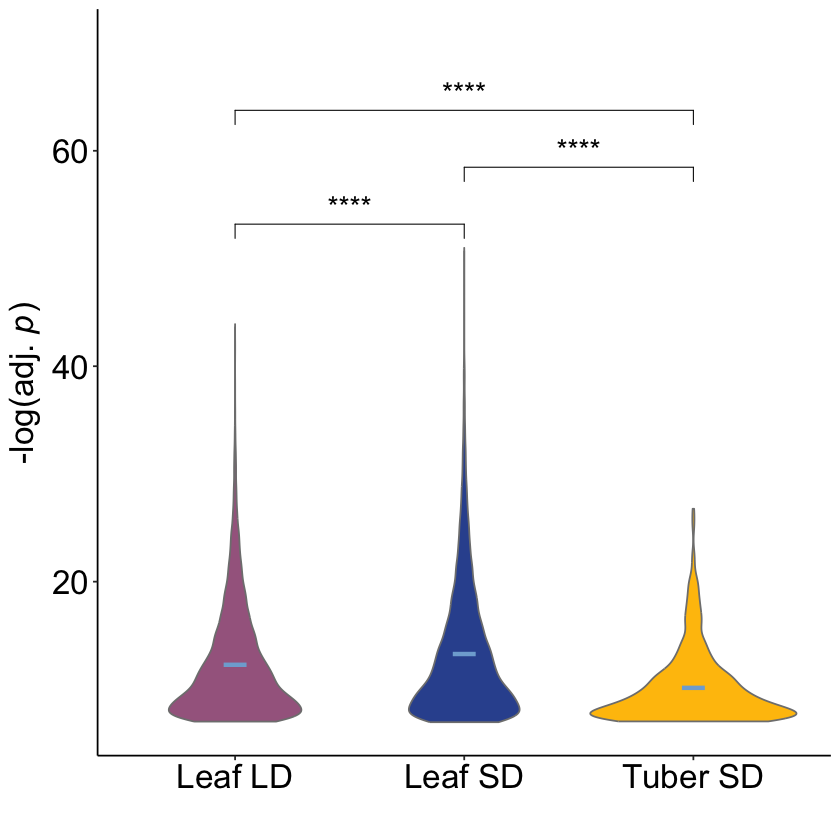

In [123]:
# LEAF & TUBER : Compare cycling by percent cycling across syntelogs: fully vs. no fully cycling WITH *** labels for statistics
#NOT MEAN BUT just adj. p-value
#::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
#Cond_labels <- c(LD = 'Leaf LD', SD= 'Leaf SD', Tuber ='Tuber SD')

Adj_p_cycling_all_LT_stat <- ExprGenes %>% select (Condition, Tissue, Syntelog, target_id, ADJ.P, ATL_alleles) %>%
            filter(!is.na(ATL_alleles),!is.na(ADJ.P))%>% 
            unique() %>% 
            mutate(Condition = case_when(Condition == 'LD' & Tissue == 'Leaf' ~ 'Leaf LD',
                                         Condition == 'SD' & Tissue == 'Leaf' ~ 'Leaf SD',
                                        Condition == 'SD' & Tissue == 'Tuber' ~ 'Tuber SD')) %>% 
         
            filter(ADJ.P < 0.001)%>% # only select cycling genes
        
            
ggplot(aes(x= Condition, y = -log(ADJ.P), color=Condition))+
              geom_violin(trim=TRUE, aes(col = 'black', fill = Condition))+  
               #geom_boxplot(aes(group = fullyCycling), width=0.1)+
            labs(y=expression(paste("-log(adj. ", italic("p"), ")")), x="")+
            stat_summary(fun = mean,
               geom = "crossbar", 
               width = 0.1,
               colour = "#7FACD6")+  #light blue

          coord_cartesian(ylim=c(7,70))+

         scale_color_manual(values = c('Leaf SD' = '#33539E', #darker blue/grey
                                    'Leaf LD'= '#A5678E',# blue
                                      'Tuber SD' = '#FFC107'))+ 
    scale_fill_manual(values = alpha(c('Leaf SD' = '#33539E', #darker blue/grey
                                    'Leaf LD'= '#A5678E',# blue
                                      'Tuber SD' = '#FFC107')))+

theme_classic()+
            theme (
            axis.title.x = element_text(size = 20),
            axis.title.y = element_text(size = 20),
            axis.text = element_text(size = 20, color = "black"),
                 strip.text.x = element_text(size = 20),
            legend.position="none",
            strip.background = element_rect(color = "white"),
          strip.placement = "inside",
          strip.text = element_text(vjust = 0)) +
              
       #stat_compare_means(method= 'kruskal.test') + #Kruskal-Wallis multiple comparisons

        
        stat_compare_means(method = 'wilcox.test', ## posthoc pairwise test
                           comparisons = list(c('Leaf SD','Leaf LD'), c('Leaf SD', 'Tuber SD'), c('Leaf LD', 'Tuber SD')), 
                           p.adjust.method = "BH" ,
                           size = 6,
                           label = "p.signif"
                          ) # Adhoc pairwise comparisons p-value, show only *** for significance
      
#http://www.sthda.com/english/articles/24-ggpubr-publication-ready-plots/76-add-p-values-and-significance-levels-to-ggplots/


Adj_p_cycling_all_LT_stat

In [124]:
## EXPORT
#::::::::::::::::::::::::::::::
Adj_p_cycling_all_LT_stat%>% ggsave(file="./Results/Adj_p-value_LDSDTuber_cyclingGenes.pdf", 
                            width=5.5, height=5, dpi=600)

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”


# Rhythmic allelic groups across conditions and tissues

In [32]:
## SHORT DAY LEAF: ALL SYNTELOGS THAT HAVE AT LEAST 1 strong cycling gene
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
SDcycSyn <- ExprGenes %>% select (Condition, Syntelog, target_id, ADJ.P, ATL_alleles, Tissue) %>%
            filter(!is.na(ATL_alleles),!is.na(ADJ.P))%>% filter(Condition == 'SD', Tissue == 'Leaf') %>%
            unique() %>%
            group_by (Syntelog) %>% 
            mutate (percentCycling = sum(ADJ.P<0.001)*100/as.numeric(as.character(ATL_alleles)))%>%
            select(Syntelog, percentCycling) %>% unique()%>%
            filter(percentCycling > 0)
            

nrow(SDcycSyn)


[1] 7625

In [33]:
## LONG DAY LEAF: ALL SYNTELOGS THAT HAVE AT LEAST 1 strong cycling gene
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
LDcycSyn <- ExprGenes %>% select (Condition, Syntelog, target_id, ADJ.P, ATL_alleles, Tissue) %>%
            filter(!is.na(ATL_alleles),!is.na(ADJ.P))%>% filter(Condition == 'LD', Tissue=='Leaf') %>%
            unique() %>%
            group_by (Syntelog) %>% 
            mutate (percentCycling = sum(ADJ.P<0.001)*100/as.numeric(as.character(ATL_alleles)))%>%
            select(Syntelog, percentCycling) %>% unique()%>%
            filter(percentCycling > 0)
            

nrow(LDcycSyn)


[1] 5604

In [34]:
## SHORT DAY TUBER: ALL SYNTELOGS THAT HAVE AT LEAST 1 strong cycling gene
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
SDcycSyn_T <- ExprGenes %>% select (Condition, Syntelog, target_id, ADJ.P, ATL_alleles, Tissue) %>%
            filter(!is.na(ATL_alleles),!is.na(ADJ.P))%>% filter(Condition == 'SD', Tissue=='Tuber') %>%
            unique() %>%
            group_by (Syntelog) %>% 
            mutate (percentCycling = sum(ADJ.P<0.001)*100/as.numeric(as.character(ATL_alleles)))%>%
            select(Syntelog, percentCycling) %>% unique()%>%
            filter(percentCycling > 0)
            

nrow(SDcycSyn_T )


[1] 449

In [35]:
VennSDLD_Tub_syn <- list('Leaf SD' = SDcycSyn$Syntelog, 'Leaf LD' = LDcycSyn$Syntelog, 'Tuber SD' = SDcycSyn_T$Syntelog)

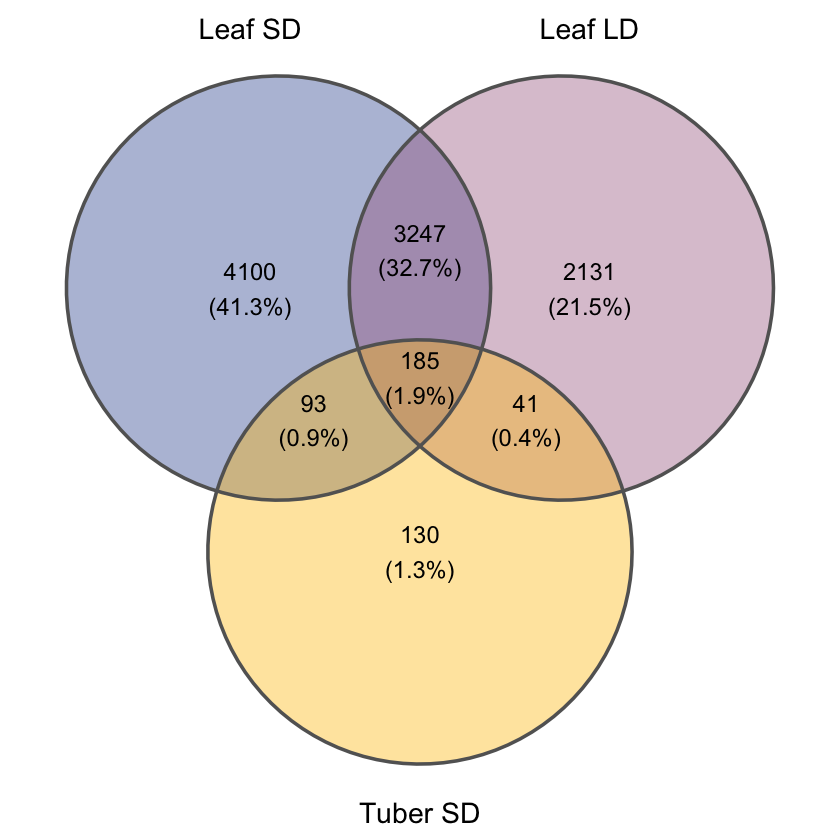

In [36]:
## Make venn diagram ##
#:::::::::::::::::::::::::::

VennSDLD_Tub_syn_plot<- ggvenn(VennSDLD_Tub_syn, c('Leaf SD', 'Leaf LD', 'Tuber SD'), 
      fill_color = c("#33539E", "#A5678E", '#FFC107'),   #c("#0073C2FF", "#CD534CFF", '#FFC107'),
      stroke_color = '#636363',
        text_size =5,
      fill_alpha = 0.4)
VennSDLD_Tub_syn_plot

In [37]:
VennSDLD_Tub_syn_plot%>% 
    ggsave(file="./Results/VennSDLD_Tub_syn_plot.pdf", 
                            width=6.75, height=5, dpi=600)

## Percent fully rhythmic allelic groups

In [38]:
 ExprGenes %>%  group_by (Syntelog, Condition, Tissue) %>% 
            mutate(PercentCycling = 100*sum(ADJ.P < 0.001)/n())%>%
            select(Condition,Tissue, PercentCycling) %>% unique() %>%

            group_by(Condition, Tissue) %>%
            
    summarize (PercentFullCyclingSyn = sum(PercentCycling == 100)*100/n())

Adding missing grouping variables: `Syntelog`
`summarise()` has grouped output by 'Condition'. You can override using the
`.groups` argument.


Condition,Tissue,PercentFullCyclingSyn
<chr>,<chr>,<dbl>
LD,Leaf,9.713267
SD,Leaf,14.480445
SD,Tuber,0.438527


# Rhythmic transcripts across tissues and conditions

In [39]:
LDLcyc <-ExprGenes %>% select(target_id,Condition, ADJ.P, Syntelog, Tissue)%>%
        unique() %>%
        filter(Condition == 'LD', Tissue == 'Leaf') %>%
            filter(ADJ.P <0.001) %>% unique()
SDLcyc<-ExprGenes %>% select(target_id,Condition, ADJ.P,Syntelog, Tissue)%>%
        unique() %>%
        filter(Condition == 'SD', Tissue == 'Leaf') %>%
            filter(ADJ.P <0.001) %>% unique()
SDTcyc<-ExprGenes %>% select(target_id,Condition, ADJ.P,Syntelog, Tissue)%>%
        unique() %>%
        filter(Condition == 'SD', Tissue == 'Tuber') %>%
            filter(ADJ.P <0.001) %>% unique()

In [40]:

VennSDLD_Tub <- list('Leaf SD' = SDLcyc$target_id, 'Leaf LD' = LDLcyc$target_id,'Tuber SD' = SDTcyc$target_id) # this allows to change the headings of the venn diagram



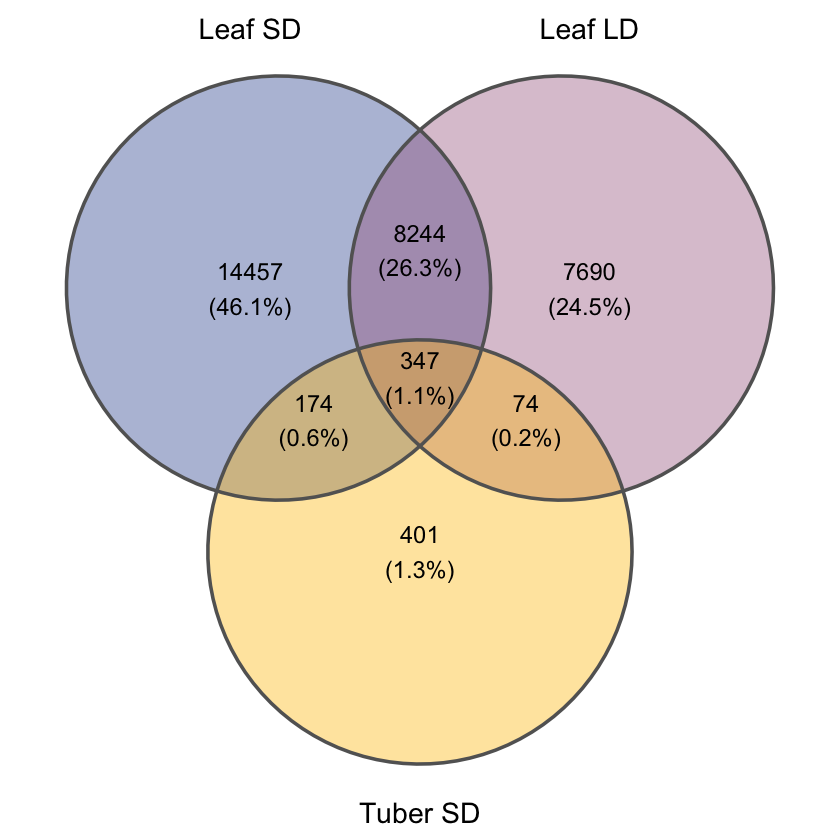

In [41]:
VennSDLD_Tub_plot<-ggvenn(VennSDLD_Tub, c('Leaf SD', 'Leaf LD', 'Tuber SD'), 
      fill_color = c("#33539E", "#A5678E", '#FFC107'),   #c("#0073C2FF", "#CD534CFF", '#FFC107'),
      stroke_color = '#636363',
        text_size =5,
      fill_alpha = 0.4)
VennSDLD_Tub_plot


In [42]:
VennSDLD_Tub_plot%>% 
    ggsave(file="./Results/VennSDLD_Tub_plot.pdf", 
                            width=6.75, height=5, dpi=600)

In [43]:
ExprGenes[1:2,]

Syntelog,Tissue,Condition,ATL_expressed_alleles,geneID,target_id,Average,SD,ATL_alleles,BH.Q,ADJ.P,Period,Adj_phase,Amplitude
<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>
Synt_1,Leaf,LD,4,Soltu.Atl_v3.01_1G000020.2,Soltu.Atl_v3.01_1G000020,7.395377,0.1577245,4,1,1,20,19,0.10051609
Synt_1,Leaf,LD,4,Soltu.Atl_v3.01_2G000020.1,Soltu.Atl_v3.01_2G000020,5.948141,0.1212230,4,1,1,20,4,0.09175902


# What are the differences in rhythmicity between alleles?

In [44]:
## LEAF & 4: MORE THAN 2 ALLELES- SYNTELOGS WITH AT LEAST ONE EXPRESSED AND CYCLING ALLELE
#:::::::::::::::::::::::::::
MixedCyclingData <-ExprGenes %>% select (Syntelog, target_id, ADJ.P, ATL_alleles, Condition, Tissue, ATL_expressed_alleles) %>%
            filter(!is.na(Syntelog), !is.na(ATL_alleles),!is.na(ADJ.P))%>% select(-ATL_alleles) %>% 
            unique() %>%
            group_by (Syntelog, Condition, Tissue) %>% 
            filter (ATL_expressed_alleles >=2) %>%  # select only genes with at least 2 cycling alleles
            mutate (percentCycling = sum(ADJ.P<0.001)*100/n())%>% 
            filter(percentCycling > 0) %>% ## SELECT GENES WITH SOME CYCLING ALLELES
            mutate(CyclingAlleles = sum(ADJ.P<0.001),
                  NotCyclingAlleles = sum(ADJ.P>=0.001 )) %>%
            ungroup() %>%

            select(Condition,Tissue, ATL_expressed_alleles, percentCycling,Syntelog) %>% unique() %>%
            select(Condition,Tissue, ATL_expressed_alleles, percentCycling) %>% 
            group_by(Condition, Tissue, ATL_expressed_alleles) %>% 
            mutate (Full_Rhythmicity = sum(percentCycling == 100)*100/n(),
                    Mixed_Rhythmicity = sum(percentCycling < 100)*100/n(),
                   AveragePercentCycling = mean(percentCycling),
                   NumberOfGenes = n()) %>% 
             ungroup() %>% select (Condition, Tissue, ATL_expressed_alleles, Full_Rhythmicity,
                                   Mixed_Rhythmicity, AveragePercentCycling, NumberOfGenes) %>% unique()





In [45]:
MixedCyclingData

Condition,Tissue,ATL_expressed_alleles,Full_Rhythmicity,Mixed_Rhythmicity,AveragePercentCycling,NumberOfGenes
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<int>
SD,Leaf,4,27.620431,72.37957,60.72380,4131
SD,Leaf,2,45.754717,54.24528,72.87736,1060
LD,Leaf,3,30.561331,69.43867,62.92446,1443
LD,Leaf,2,42.737430,57.26257,71.36872,716
SD,Tuber,2,23.728814,76.27119,61.86441,59
LD,Leaf,4,25.056072,74.94393,58.45082,3121
SD,Leaf,3,32.606438,67.39356,64.79751,1926
SD,Tuber,4,9.090909,90.90909,42.20779,231
SD,Tuber,3,13.281250,86.71875,48.17708,128


In [46]:
MixedCyclingLong <- MixedCyclingData %>% select(-AveragePercentCycling, -NumberOfGenes)%>%
                pivot_longer(cols= ends_with('Rhythmicity'), names_to = 'Rhythmicity', values_to = 'PercentGenes')
MixedCyclingLong

Condition,Tissue,ATL_expressed_alleles,Rhythmicity,PercentGenes
<chr>,<chr>,<int>,<chr>,<dbl>
SD,Leaf,4,Full_Rhythmicity,27.620431
SD,Leaf,4,Mixed_Rhythmicity,72.379569
SD,Leaf,2,Full_Rhythmicity,45.754717
SD,Leaf,2,Mixed_Rhythmicity,54.245283
LD,Leaf,3,Full_Rhythmicity,30.561331
LD,Leaf,3,Mixed_Rhythmicity,69.438669
LD,Leaf,2,Full_Rhythmicity,42.737430
LD,Leaf,2,Mixed_Rhythmicity,57.262570
SD,Tuber,2,Full_Rhythmicity,23.728814


Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”


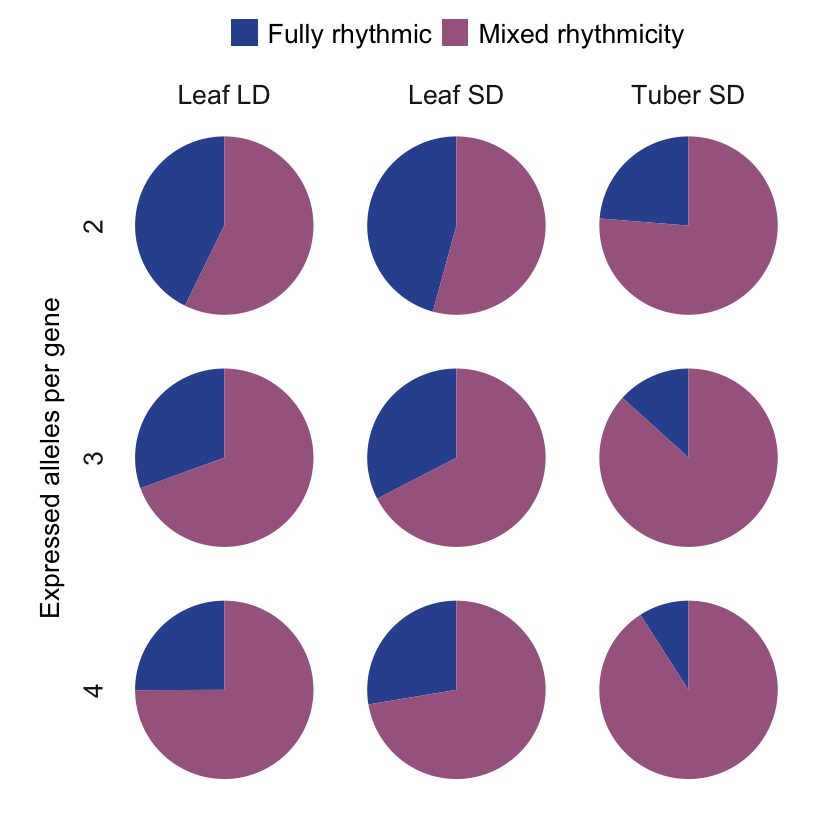

In [107]:


MixedCycling_Pie_plot<- MixedCyclingLong %>% #filter(Condition == 'SD') %>% 
                mutate(ATL_expressed_alleles = as.factor(ATL_expressed_alleles)) %>%

mutate(Condition = case_when(Condition == 'LD' & Tissue == 'Leaf' ~ 'Leaf LD',
                                         Condition == 'SD' & Tissue == 'Leaf' ~ 'Leaf SD',
                                        Condition == 'SD' & Tissue == 'Tuber' ~ 'Tuber SD')) %>% 

                    ggplot(aes(x='', y=PercentGenes, fill =Rhythmicity)) +
     geom_bar(stat="identity", width=1) +
      coord_polar("y", start=0)+

 facet_grid(ATL_expressed_alleles ~ Condition,
           switch = "y")+
           #labeller = labeller(Condition = Cond_labels1))

    theme_bw()+
    theme(panel.grid.major = element_blank(), 
      panel.grid.minor = element_blank(),
     panel.border = element_blank(),
            axis.title.x = element_text(size = 16),
            axis.title.y = element_text(size = 16),
            axis.text.x=element_blank(),
      strip.text.x = element_text(size = 16),
        strip.text.y = element_text(size = 16),
         axis.ticks.length=unit(0,"cm"),

      strip.background = element_blank(),
      legend.text=element_text(size=16),
           legend.position="top",
            legend.title = element_blank())+


scale_color_manual(values = c('Full_Rhythmicity' = '#33539E', #darker blue/grey #1F449C
                                    'Mixed_Rhythmicity'= '#A5678E'
                                      ))+ # blue

            scale_fill_manual(values = c('Full_Rhythmicity' = '#33539E', #darker blue/grey  #1F449C'
                                    'Mixed_Rhythmicity'= '#A5678E'),  #7CA1CC
                                     labels = c('Fully rhythmic','Mixed rhythmicity' ))+ 

labs(y="", x="Expressed alleles per gene")



           

MixedCycling_Pie_plot
    

In [108]:
MixedCycling_Pie_plot%>% ggsave(file="./Results/MixedCycling_Pie_plot.pdf", 
                            width=6.75, height=5, dpi=600)

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”


# What the likelihood of rhythmicity within rhythmic genes?

In [49]:
CyclingSynOnly<- ExprGenes %>% select (Condition, Tissue, Syntelog, target_id, ADJ.P, ATL_expressed_alleles) %>% filter(!is.na(Syntelog)) %>%
mutate(Condition = case_when(Condition == 'LD' & Tissue == 'Leaf' ~ 'Leaf LD',
                                         Condition == 'SD' & Tissue == 'Leaf' ~ 'Leaf SD',
                                        Condition == 'SD' & Tissue == 'Tuber' ~ 'Tuber SD')) %>% 
            filter(!is.na(ADJ.P), !is.na(Syntelog))%>%   ### Get all genes in syntelogs
            select(-Tissue) %>%
            unique() %>% 

            mutate(ATL_expressed_alleles = factor(ATL_expressed_alleles))%>%
            group_by (Syntelog, Condition) %>% 
            mutate (PercentCycling = sum(ADJ.P<0.001)*100/n()) %>% # used only expressed alleles
            ungroup() %>% 
            mutate(Syntelog_type = case_when(PercentCycling > 0 ~ 'Cycling',
                                        PercentCycling == 0 ~ 'NC')) %>%
            ungroup() %>%
            group_by(ATL_expressed_alleles, Syntelog_type, Condition) %>%  
            summarize(CyclingLikeliHood = sum(sum(ADJ.P<0.001)/n())) %>% ## Calculate chance of cycling within cycling syntelogs
            filter(Syntelog_type == 'Cycling')
CyclingSynOnly

`summarise()` has grouped output by 'ATL_expressed_alleles', 'Syntelog_type'.
You can override using the `.groups` argument.


ATL_expressed_alleles,Syntelog_type,Condition,CyclingLikeliHood
<fct>,<chr>,<chr>,<dbl>
1,Cycling,Leaf LD,1.0000000
1,Cycling,Leaf SD,1.0000000
1,Cycling,Tuber SD,1.0000000
2,Cycling,Leaf LD,0.7136872
2,Cycling,Leaf SD,0.7287736
2,Cycling,Tuber SD,0.6186441
3,Cycling,Leaf LD,0.6292446
3,Cycling,Leaf SD,0.6479751
3,Cycling,Tuber SD,0.4817708


In [50]:
# The minimum likelihood of one additional cycling allele within cycling genes
MinCycRate <- data.frame(ATL_expressed_alleles = c(1,1,1,2,2,2,3,3,3,4,4,4), 
                         Condition = c('Leaf LD', 'Leaf SD', 'Tuber SD','Leaf LD', 'Leaf SD', 'Tuber SD','Leaf LD', 'Leaf SD', 'Tuber SD',
                                       'Leaf LD', 'Leaf SD', 'Tuber SD'), 
                         CyclingLikeliHood = c(1,1,1,0.5,0.5,0.5,1/3,1/3,1/3,0.25,0.25,0.25))
MinCycRate

ATL_expressed_alleles,Condition,CyclingLikeliHood
<dbl>,<chr>,<dbl>
1,Leaf LD,1.0000000
1,Leaf SD,1.0000000
1,Tuber SD,1.0000000
2,Leaf LD,0.5000000
2,Leaf SD,0.5000000
2,Tuber SD,0.5000000
3,Leaf LD,0.3333333
3,Leaf SD,0.3333333
3,Tuber SD,0.3333333


Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”


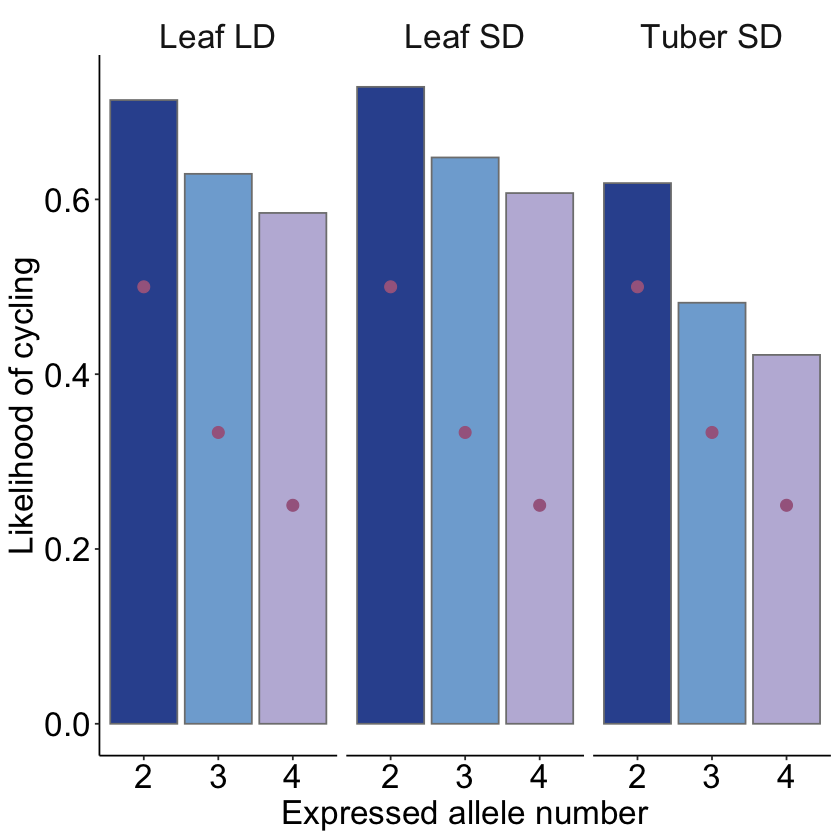

In [51]:


CyclingSynOnly_plot <- CyclingSynOnly %>%  filter(as.numeric(ATL_expressed_alleles) >1) %>%  

        ggplot(aes(x= as.numeric(ATL_expressed_alleles), y = CyclingLikeliHood))+
            geom_bar(stat= 'identity',aes(col = 'black', fill = ATL_expressed_alleles))+ 
            labs(y="Likelihood of cycling", x="Expressed allele number")+

   
            scale_color_manual(values = c(
                                 '2'= '#33539E', #'#7CA1CC'
                                   '3'= '#7FACD6', #'#3D65A5'
                                  '4'='#BFB8DA'))+ #'#1F449C'
            scale_fill_manual(values = alpha(c(
                                 '2'= '#33539E', #'#7CA1CC'
                                   '3'= '#7FACD6', #'#3D65A5'
                                  '4'='#BFB8DA')))+ #'#1F449C' 
   theme_classic()+
            theme (
            axis.title.x = element_text(size = 20),
            axis.title.y = element_text(size = 20),
            axis.text = element_text(size = 20, color = "black"),
                 strip.text.x = element_text(size = 20),
            legend.position="none",
            strip.background = element_rect(color = "white"),
          strip.placement = "inside",
          strip.text = element_text(vjust = 0)) +
               #plot.title = element_text(size = 14)


geom_point( data = MinCycRate %>% filter(as.numeric(ATL_expressed_alleles) >1),
        
           aes( x = ATL_expressed_alleles, y= CyclingLikeliHood), 
           
           colour = '#A5678E', size = 3)+


facet_grid(cols = vars(Condition))

CyclingSynOnly_plot

In [52]:
## EXPORT
#::::::::::::::::::::::::::::::
CyclingSynOnly_plot%>% ggsave(file="./Results/CyclingSynOnly_plot.pdf", 
                            width=6.75, height=5, dpi=600)

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”


## Number of expressed alleles of cycling and not cycling genes

In [53]:
ExprGenes[1:2,]

Syntelog,Tissue,Condition,ATL_expressed_alleles,geneID,target_id,Average,SD,ATL_alleles,BH.Q,ADJ.P,Period,Adj_phase,Amplitude
<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>
Synt_1,Leaf,LD,4,Soltu.Atl_v3.01_1G000020.2,Soltu.Atl_v3.01_1G000020,7.395377,0.1577245,4,1,1,20,19,0.10051609
Synt_1,Leaf,LD,4,Soltu.Atl_v3.01_2G000020.1,Soltu.Atl_v3.01_2G000020,5.948141,0.1212230,4,1,1,20,4,0.09175902


In [54]:
ExprGenes %>% select (Condition, Tissue, Syntelog, target_id, ADJ.P, ATL_expressed_alleles) %>%

            filter(!is.na(Syntelog),!is.na(ADJ.P), !is.na(Syntelog))%>%   ### Get all genes in syntelogs
            unique() %>% 

            group_by (Syntelog, Condition, Tissue) %>% 
            mutate (PercentCycling = sum(ADJ.P<0.001)*100/n()) %>% # used only expressed alleles
            ungroup() %>% 
            mutate(Gene_type = case_when(PercentCycling > 0 ~ 'Cycling',
                                        PercentCycling == 0 ~ 'NC')) %>%
            ungroup() %>%
            group_by(Gene_type, Condition, Tissue) %>%  
            summarize(AvAlleleNumber = mean(ATL_expressed_alleles))  


`summarise()` has grouped output by 'Gene_type', 'Condition'. You can override
using the `.groups` argument.


Gene_type,Condition,Tissue,AvAlleleNumber
<chr>,<chr>,<chr>,<dbl>
Cycling,LD,Leaf,3.560289
Cycling,SD,Leaf,3.537024
Cycling,SD,Tuber,3.510638
NC,LD,Leaf,3.323946
NC,SD,Leaf,3.289596
NC,SD,Tuber,3.384438


In [55]:
## LD leaf test#
#:::::::::::::::::::
ExprGenes %>% select (Condition, Tissue, Syntelog, target_id, ADJ.P, ATL_expressed_alleles) %>%

            filter(!is.na(Syntelog),!is.na(ADJ.P), !is.na(Syntelog))%>%   ### Get all genes in syntelogs
            unique() %>% 

            group_by (Syntelog, Condition, Tissue) %>% 
            mutate (PercentCycling = sum(ADJ.P<0.001)*100/n()) %>% # used only expressed alleles
            ungroup() %>% 
            mutate(Gene_type = case_when(PercentCycling > 0 ~ 'Cycling',
                                        PercentCycling == 0 ~ 'NC')) %>%
            ungroup() %>%select(Syntelog, Gene_type, Condition, Tissue, ATL_expressed_alleles) %>% unique()%>%
            filter(Condition == 'LD', Tissue == 'Leaf') %>%  
            kruskal.test(ATL_expressed_alleles ~ Gene_type)

Warning message in kruskal.test.default(., ATL_expressed_alleles ~ Gene_type):
“'x' is a list, so ignoring argument 'g'”
Warning message in kruskal.test.default(., ATL_expressed_alleles ~ Gene_type):
“some elements of 'x' are not numeric and will be coerced to numeric”



	Kruskal-Wallis rank sum test

data:  .
Kruskal-Wallis chi-squared = 81797, df = 4, p-value < 2.2e-16


In [56]:
## SD leaf test#
#:::::::::::::::::::
ExprGenes %>% select (Condition, Tissue, Syntelog, target_id, ADJ.P, ATL_expressed_alleles) %>%

            filter(!is.na(Syntelog),!is.na(ADJ.P), !is.na(Syntelog))%>%   ### Get all genes in syntelogs
            unique() %>% 

            group_by (Syntelog, Condition, Tissue) %>% 
            mutate (PercentCycling = sum(ADJ.P<0.001)*100/n()) %>% # used only expressed alleles
            ungroup() %>% 
            mutate(Gene_type = case_when(PercentCycling > 0 ~ 'Cycling',
                                        PercentCycling == 0 ~ 'NC')) %>%
            ungroup() %>%select(Syntelog, Gene_type, Condition, Tissue, ATL_expressed_alleles) %>% unique()%>%
            filter(Condition == 'SD', Tissue == 'Leaf') %>%  
            kruskal.test(ATL_expressed_alleles ~ Gene_type)

Warning message in kruskal.test.default(., ATL_expressed_alleles ~ Gene_type):
“'x' is a list, so ignoring argument 'g'”
Warning message in kruskal.test.default(., ATL_expressed_alleles ~ Gene_type):
“some elements of 'x' are not numeric and will be coerced to numeric”



	Kruskal-Wallis rank sum test

data:  .
Kruskal-Wallis chi-squared = 88858, df = 4, p-value < 2.2e-16


In [57]:
## SD tuber test#
#:::::::::::::::::::
ExprGenes %>% select (Condition, Tissue, Syntelog, target_id, ADJ.P, ATL_expressed_alleles) %>%

            filter(!is.na(Syntelog),!is.na(ADJ.P), !is.na(Syntelog))%>%   ### Get all genes in syntelogs
            unique() %>% 

            group_by (Syntelog, Condition, Tissue) %>% 
            mutate (PercentCycling = sum(ADJ.P<0.001)*100/n()) %>% # used only expressed alleles
            ungroup() %>% 
            mutate(Gene_type = case_when(PercentCycling > 0 ~ 'Cycling',
                                        PercentCycling == 0 ~ 'NC')) %>%
            ungroup() %>%select(Syntelog, Gene_type, Condition, Tissue, ATL_expressed_alleles) %>% unique()%>%
            filter(Condition == 'SD', Tissue == 'Tuber') %>%  
            kruskal.test(ATL_expressed_alleles ~ Gene_type)

Warning message in kruskal.test.default(., ATL_expressed_alleles ~ Gene_type):
“'x' is a list, so ignoring argument 'g'”
Warning message in kruskal.test.default(., ATL_expressed_alleles ~ Gene_type):
“some elements of 'x' are not numeric and will be coerced to numeric”



	Kruskal-Wallis rank sum test

data:  .
Kruskal-Wallis chi-squared = 93109, df = 4, p-value < 2.2e-16


# Do genes with more rhythmic alleles have stronger rhythmicity?

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”


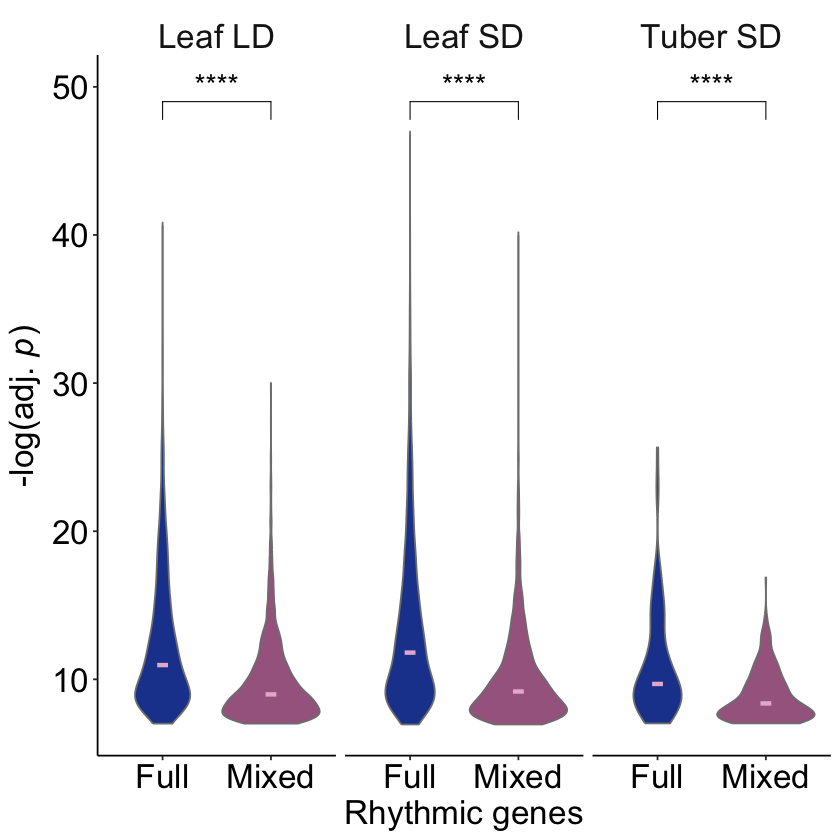

In [111]:
# LEAF & TUBER : Compare cycling by percent cycling across syntelogs: fully vs. no fully cycling WITH *** labels for statistics
#::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::


Hapl_cycling_LT_stat <- ExprGenes %>% select (Condition, Syntelog, target_id, ADJ.P,  Tissue) %>%
            filter(!is.na(Syntelog),!is.na(ADJ.P))%>% 
            unique() %>% 
            mutate(Condition = case_when(Condition == 'LD' & Tissue == 'Leaf' ~ 'Leaf LD',
                                         Condition == 'SD' & Tissue == 'Leaf' ~ 'Leaf SD',
                                        Condition == 'SD' & Tissue == 'Tuber' ~ 'Tuber SD')) %>% 
            
            group_by (Syntelog, Condition) %>% 
            mutate (percentCycling = sum(ADJ.P<0.001)*100/n(),
                   Cycling = case_when(percentCycling == 100 ~ 'Full',
                                          percentCycling < 100 & percentCycling > 0 ~ 'Mixed',
                                        percentCycling == 0 ~ 'NC')) %>% 
            ungroup() %>% 
            mutate(Cycling = as.factor(Cycling))%>%
            filter (!Cycling == 'NC') %>% # only select syntelog with some cycling alleles
            filter(ADJ.P < 0.001)%>% # ONLY select cycling transcripts
            group_by(Syntelog, Condition) %>%
            mutate(AveCycOfCyclers = mean(ADJ.P)) %>% # calculate average P value of only cyclers
            ungroup() %>% 
    select(Condition, Syntelog, percentCycling, Cycling,AveCycOfCyclers) %>% unique() %>%
            
ggplot(aes(x= Cycling, y = -log(AveCycOfCyclers), color=Cycling))+
              geom_violin(trim=TRUE, aes(col = 'black', fill = Cycling))+  
               #geom_boxplot(aes(group = Cycling), width=0.1)+
            labs(y=expression(paste("-log(adj. ",italic("p"),")")), x="Rhythmic genes")+  
            stat_summary(fun = median,
               geom = "crossbar", 
               width = 0.1,
               colour = "#E8B7D4")+  
          coord_cartesian(ylim=c(7,50))+
         scale_color_manual(values = c('Mixed' = '#A5678E', #darker blue/grey#7CA1CC
                                    'Full'= '#1F449C'))+ # blue
    scale_fill_manual(values = alpha(c('Mixed' = '#A5678E',   #A5678E
                                    'Full'= '#1F449C')))+


theme_classic()+
            theme (
            axis.title.x = element_text(size = 20),
            axis.title.y = element_text(size = 20),
            axis.text = element_text(size = 20, color = "black"),
                 strip.text.x = element_text(size = 20),
            legend.position="none",
            strip.background = element_rect(color = "white"),
          strip.placement = "inside",
          strip.text = element_text(vjust = 0)) +
               
        facet_grid(cols = vars(Condition))+
      # stat_compare_means(method= 'kruskal.test') + #Kruskal-Wallis multiple comparisons

        
        stat_compare_means(method = 'wilcox.test', ## posthoc pairwise test
                           comparisons = list(c('Full','Mixed')),  p.adjust.method = "BH" ,
                           size = 6,
                           label = "p.signif",
                          label.y = 47) # Adhoc pairwise comparisons p-value, show only *** for significance
      
#http://www.sthda.com/english/articles/24-ggpubr-publication-ready-plots/76-add-p-values-and-significance-levels-to-ggplots/


Hapl_cycling_LT_stat

In [59]:
ExprGenes %>% select (Condition, Syntelog, target_id, ADJ.P, ATL_expressed_alleles, Tissue) %>%
            filter(!is.na(Syntelog),!is.na(ADJ.P))%>% 
            unique() %>% 
            mutate(Condition = case_when(Condition == 'LD' & Tissue == 'Leaf' ~ 'Leaf LD',
                                         Condition == 'SD' & Tissue == 'Leaf' ~ 'Leaf SD',
                                        Condition == 'SD' & Tissue == 'Tuber' ~ 'Tuber SD')) %>% 
            mutate(ATL_expressed_alleles = as.factor(ATL_expressed_alleles))%>%
            group_by (Syntelog, Condition) %>% 
            mutate (percentCycling = sum(ADJ.P<0.001)*100/n(),   #only expressed alleles in each condition
                   Cycling = case_when(percentCycling == 100 ~ 'Full',
                                          percentCycling < 100 & percentCycling > 0 ~ 'Mixed',
                                        percentCycling == 0 ~ 'NC')) %>% 
            ungroup() %>% 
            mutate(Cycling = as.factor(Cycling))%>%
            filter (!Cycling == 'NC') %>% # only select syntelog with some cycling alleles
            filter(ADJ.P < 0.001)%>% # ONLY select cycling transcripts
            group_by(Syntelog, Condition) %>%
            mutate(AveCycOfCyclers = mean(ADJ.P)) %>% # calculate average P value of only cyclers
            ungroup() %>% select(Condition, Syntelog, ATL_expressed_alleles, percentCycling, Cycling,AveCycOfCyclers) %>% 
            unique() %>% head()

Condition,Syntelog,ATL_expressed_alleles,percentCycling,Cycling,AveCycOfCyclers
<chr>,<chr>,<fct>,<dbl>,<fct>,<dbl>
Leaf SD,Synt_1,4,25.00000,Mixed,3.020109e-04
Leaf SD,Synt_10,2,50.00000,Mixed,4.027794e-06
Leaf LD,Synt_100,3,33.33333,Mixed,1.594926e-05
Leaf LD,Synt_10002,2,100.00000,Full,8.494046e-04
Leaf SD,Synt_10002,2,50.00000,Mixed,3.153539e-05
Tuber SD,Synt_10003,2,50.00000,Mixed,6.197426e-05


In [112]:
## EXPORT- NOT ALWAYS NEEDED
#::::::::::::::::::::::::::::::
Hapl_cycling_LT_stat%>% ggsave(file="./Results/MixedCycling_AdjP_plot.pdf", 
                            width=6.75, height=5, dpi=600)

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”


# Are alleles of fully cycling genes higher expressed?

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”


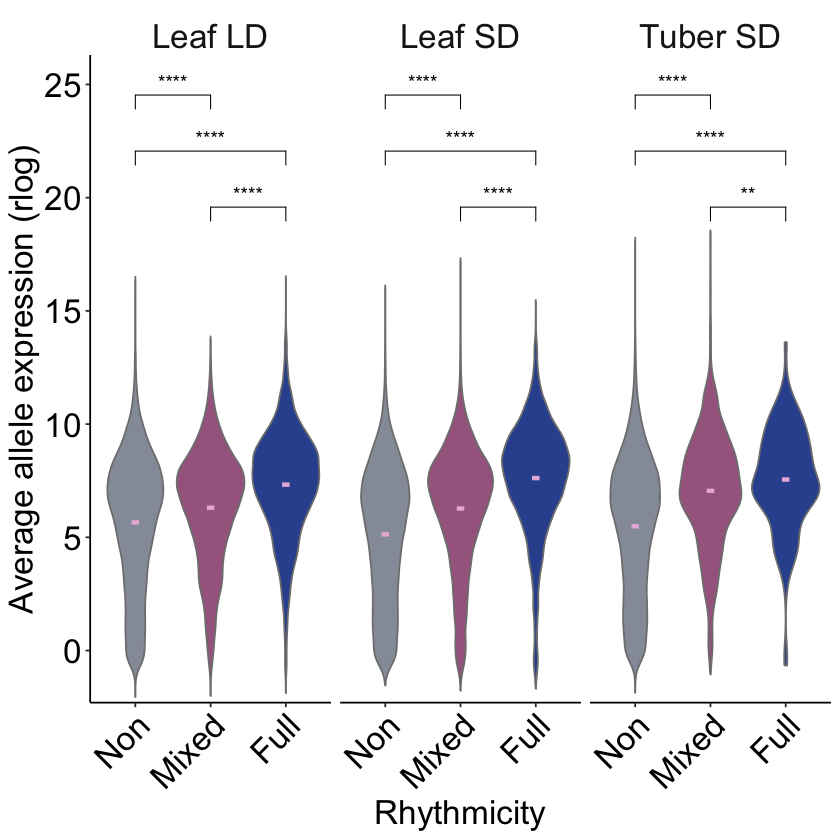

In [115]:


ExpressionCycling<- ExprGenes %>% select (Condition, Syntelog, target_id, ADJ.P, ATL_expressed_alleles, Average, Tissue) %>%
            filter(!is.na(Syntelog),!is.na(ADJ.P))%>% 
            unique() %>% 
            mutate(Condition = case_when(Condition == 'LD' & Tissue == 'Leaf' ~ 'Leaf LD',
                                         Condition == 'SD' & Tissue == 'Leaf' ~ 'Leaf SD',
                                        Condition == 'SD' & Tissue == 'Tuber' ~ 'Tuber SD')) %>% 
            mutate(ATL_expressed_alleles = factor(ATL_expressed_alleles))%>%
            group_by (Syntelog, Condition) %>% 
            mutate (percentCycling = sum(ADJ.P<0.001)*100/n(),# used only expressed alleles
                   Cycling = case_when(percentCycling == 0 ~ 'Non',
                                          percentCycling < 100 & percentCycling > 0 ~ 'Mixed',
                                        percentCycling == 100 ~ 'Full')) %>% 
            ungroup() %>% 
            mutate(Cycling = factor(Cycling, levels = c('Non','Mixed', 'Full')))%>%
    select(Condition, Syntelog, target_id, ATL_expressed_alleles, Cycling,Average) %>% unique() %>%
            
ggplot(aes(x= Cycling, y = Average, color=Cycling))+
                   
              geom_violin(trim=TRUE, aes(col = 'black', fill = Cycling))+  
               #geom_boxplot(aes(group = fullyCycling), width=0.1)+
            
                   labs(y="Average allele expression (rlog)", x="Rhythmicity")+
            
            stat_summary(fun = mean,
               geom = "crossbar", 
               width = 0.1,
               colour = "#E8B7DA")+  
                   
          coord_cartesian(ylim=c(-1,25)) +
 
         scale_color_manual(values = c('Full' = '#33539E',  ##1F449C #darker blue/grey
                                    'Mixed'= '#A5678E',   ##7CA1CC
                                      'Non' = '#969ba8'))+ # blue
    scale_fill_manual(values = alpha(c('Full' = '#33539E', #darker blue/grey  '#1F449C'
                                    'Mixed'= '#A5678E',   #7CA1CC
                                      'Non' = '#969ba8')))+
theme_classic()+
            theme (
            axis.title.x = element_text(size = 20),
            axis.title.y = element_text(size = 20),
            axis.text = element_text(size = 20, color = "black"),
                axis.text.x = element_text(angle = 45, vjust = 1, hjust=1),
                 strip.text.x = element_text(size = 20),
            legend.position="none",
            strip.background = element_rect(color = "white"),
          strip.placement = "inside",
          strip.text = element_text(vjust = 0)) +
               
        facet_grid(cols = vars(Condition))+
                  
     #stat_compare_means(method= 'kruskal.test') + #Kruskal-Wallis multiple comparisons
        
        stat_compare_means(method = 'wilcox.test', ## for posthoc pairwise test
                           comparisons = list(c('Full','Mixed'), c('Full', 'Non'), c('Non','Mixed')),  p.adjust.method = "BH" ,
                           size = 4,
                           label = "p.signif"
                          )

      

ExpressionCycling

In [116]:
## EXPORT- NOT ALWAYS NEEDED
#::::::::::::::::::::::::::::::
ExpressionCycling%>% ggsave(file="./Results/ExpressionCycling_plot.pdf", 
                            width=7.25, height=5, dpi=600)

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”


In [63]:
ExprGenes %>% filter(Syntelog == '')

Syntelog,Tissue,Condition,ATL_expressed_alleles,geneID,target_id,Average,SD,ATL_alleles,BH.Q,ADJ.P,Period,Adj_phase,Amplitude
<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>


### Are cycling specific expression differences also occurred within highly expressed transcripts

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”


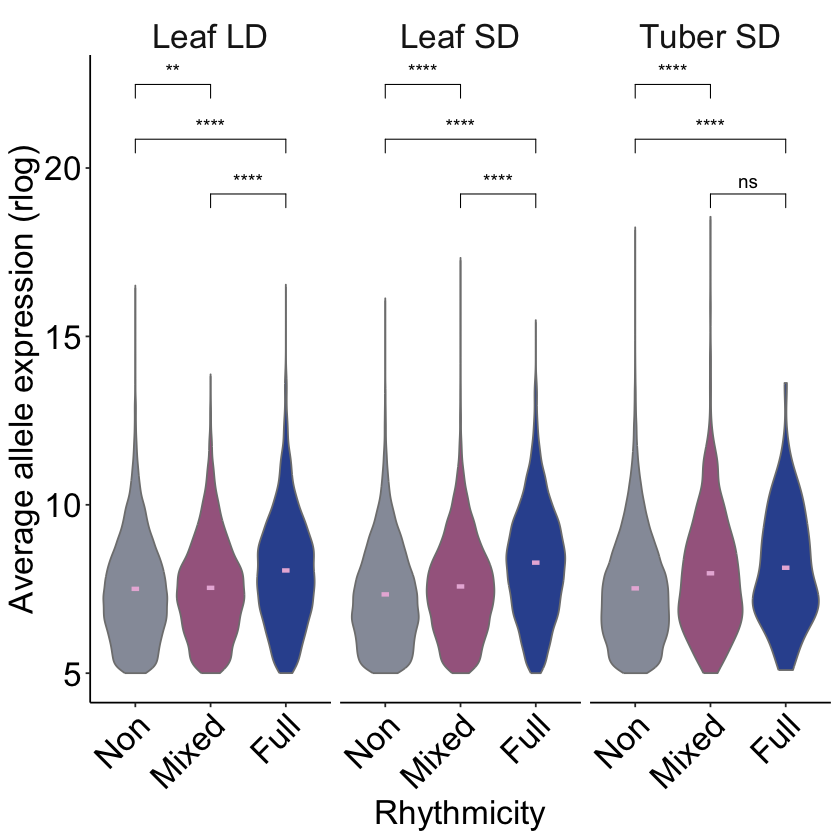

In [117]:


ExpressionCyclingHigh<- ExprGenes %>% select (Condition, Syntelog, target_id, ADJ.P, ATL_expressed_alleles, Average, Tissue) %>%
            filter(!is.na(Syntelog),!is.na(ADJ.P))%>% 
            unique() %>% 
            mutate(Condition = case_when(Condition == 'LD' & Tissue == 'Leaf' ~ 'Leaf LD',
                                         Condition == 'SD' & Tissue == 'Leaf' ~ 'Leaf SD',
                                        Condition == 'SD' & Tissue == 'Tuber' ~ 'Tuber SD')) %>% 
           
            group_by (Syntelog, Condition) %>% 
            mutate (percentCycling = sum(ADJ.P<0.001)*100/n(),# used only expressed alleles
                   Cycling = case_when(percentCycling == 0 ~ 'Non',
                                          percentCycling < 100 & percentCycling > 0 ~ 'Mixed',
                                        percentCycling == 100 ~ 'Full')) %>% 
            ungroup() %>% 
            mutate(Cycling = factor(Cycling, levels = c('Non','Mixed', 'Full')))%>%
    select(Condition, Syntelog, target_id, ATL_expressed_alleles, Cycling,Average) %>% unique() %>%

 filter(Average > 5)%>%  ## ONLY GENES WITH AVERAGE RLOG >5 ARE CHOSEN
#::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
            
ggplot(aes(x= Cycling, y = Average, color=Cycling))+
                   
              geom_violin(trim=TRUE, aes(col = 'black', fill = Cycling))+  
               #geom_boxplot(aes(group = fullyCycling), width=0.1)+
            
                   labs(y="Average allele expression (rlog)", x="Rhythmicity")+
            
            stat_summary(fun = mean,
               geom = "crossbar", 
               width = 0.1,
               colour = "#E8B7DA")+  
                   
        #  coord_cartesian(ylim=c(-1,26)) +
 
         scale_color_manual(values = c('Full' = '#33539E',  ##1F449C #darker blue/grey
                                    'Mixed'= '#A5678E',   ##7CA1CC
                                      'Non' = '#969ba8'))+ # blue
    scale_fill_manual(values = alpha(c('Full' = '#33539E', #darker blue/grey  '#1F449C'
                                    'Mixed'= '#A5678E',   #7CA1CC
                                      'Non' = '#969ba8')))+
theme_classic()+
            theme (
            axis.title.x = element_text(size = 20),
            axis.title.y = element_text(size = 20),
            axis.text = element_text(size = 20, color = "black"),
                 strip.text.x = element_text(size = 20),
                axis.text.x = element_text(angle = 45, vjust = 1, hjust=1),
            legend.position="none",
            strip.background = element_rect(color = "white"),
          strip.placement = "inside",
          strip.text = element_text(vjust = 0)) +
               
        facet_grid(cols = vars(Condition))+
                  
     #stat_compare_means(method= 'kruskal.test') + #Kruskal-Wallis multiple comparisons
        
        stat_compare_means(method = 'wilcox.test', ## for posthoc pairwise test
                           comparisons = list(c('Full','Mixed'), c('Full', 'Non'), c('Non','Mixed')),  p.adjust.method = "BH" ,
                           size = 4,
                           label = "p.signif"
                          )

      

ExpressionCyclingHigh

In [118]:
## EXPORT- NOT ALWAYS NEEDED
#::::::::::::::::::::::::::::::
ExpressionCyclingHigh%>% ggsave(file="./Results/ExpressionCyclingHigh_plot.pdf", 
                            width=7.25, height=5, dpi=600)

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”


# Comparison of expression level between cycling and not cycling alleles in allelic pairs

In [66]:
SynPairs<- import(file = '../ATL_ExpressedAllelicPairs/Results/ExpressedAllelicPairs.csv', sep =',', header = TRUE, fill = TRUE )

In [67]:
head(SynPairs)

,Syntelog,Alleles,Allele1,Allele2
,<chr>,<int>,<chr>,<chr>
1,Synt_1,4,Soltu.Atl_v3.01_1G000020.2,Soltu.Atl_v3.01_2G000020.1
2,Synt_1,4,Soltu.Atl_v3.01_1G000020.2,Soltu.Atl_v3.01_3G000040.1
3,Synt_1,4,Soltu.Atl_v3.01_1G000020.2,Soltu.Atl_v3.01_4G000020.2
4,Synt_1,4,Soltu.Atl_v3.01_2G000020.1,Soltu.Atl_v3.01_3G000040.1
5,Synt_1,4,Soltu.Atl_v3.01_2G000020.1,Soltu.Atl_v3.01_4G000020.2
6,Synt_1,4,Soltu.Atl_v3.01_3G000040.1,Soltu.Atl_v3.01_4G000020.2


In [68]:
SynPairs<- SynPairs %>% mutate(PairID=row_number())
SynPairs[1:2,]

,Syntelog,Alleles,Allele1,Allele2,PairID
,<chr>,<int>,<chr>,<chr>,<int>
1,Synt_1,4,Soltu.Atl_v3.01_1G000020.2,Soltu.Atl_v3.01_2G000020.1,1
2,Synt_1,4,Soltu.Atl_v3.01_1G000020.2,Soltu.Atl_v3.01_3G000040.1,2


In [69]:
nrow(SynPairs)

[1] 70057

In [70]:
CycExprGenes <- ExprGenes %>% select (Condition, Syntelog, geneID, ADJ.P, Average, Tissue) %>%
            filter(!is.na(Syntelog),!is.na(ADJ.P))%>% 
            unique() %>% 
            mutate(Condition = case_when(Condition == 'LD' & Tissue == 'Leaf' ~ 'Leaf LD',
                                         Condition == 'SD' & Tissue == 'Leaf' ~ 'Leaf SD',
                                        Condition == 'SD' & Tissue == 'Tuber' ~ 'Tuber SD')) %>% 


            mutate (Cycling = case_when(ADJ.P < 0.001 ~ 'Yes',
                                      ADJ.P >= 0.001 ~ 'No')) %>% 

            mutate(Cycling = as.factor(Cycling))%>%
        mutate(Cycling = factor(Cycling, levels=c("No", "Yes"))) %>%
        mutate(Condition = as.factor(Condition))%>%
        mutate(Condition = factor(Condition, levels=c( "Leaf LD","Leaf SD", 'Tuber SD'))) %>%        
        select(Condition, geneID, Cycling, Average)

CycExprGenes[1:2,]

Condition,geneID,Cycling,Average
<fct>,<chr>,<fct>,<dbl>
Leaf LD,Soltu.Atl_v3.01_1G000020.2,No,7.395377
Leaf LD,Soltu.Atl_v3.01_2G000020.1,No,5.948141


In [71]:
SynPairs<-SynPairs %>% left_join(CycExprGenes, c('Allele1'='geneID'), relationship = 'many-to-many') %>%
                                       rename(
                                             'Cycling1' = 'Cycling',
                                             'Average1' = 'Average') %>%
                                    left_join(CycExprGenes, c('Allele2'='geneID', 'Condition' = 'Condition'), relationship = 'many-to-many') %>%
                                       rename(
                                             'Cycling2' = 'Cycling',
                                             'Average2' = 'Average')

                                          
SynPairs[1:2,]

,Syntelog,Alleles,Allele1,Allele2,PairID,Condition,Cycling1,Average1,Cycling2,Average2
,<chr>,<int>,<chr>,<chr>,<int>,<fct>,<fct>,<dbl>,<fct>,<dbl>
1,Synt_1,4,Soltu.Atl_v3.01_1G000020.2,Soltu.Atl_v3.01_2G000020.1,1,Leaf LD,No,7.395377,No,5.948141
2,Synt_1,4,Soltu.Atl_v3.01_1G000020.2,Soltu.Atl_v3.01_2G000020.1,1,Leaf SD,Yes,7.782333,No,6.288177


In [72]:
SynPairs<-SynPairs %>% select(PairID, Condition, Cycling1, Average1, Cycling2, Average2) %>% filter(Cycling1 != Cycling2)
SynPairs[1:3,]

,PairID,Condition,Cycling1,Average1,Cycling2,Average2
,<int>,<fct>,<fct>,<dbl>,<fct>,<dbl>
1,1,Leaf SD,Yes,7.782333,No,6.288177
2,2,Leaf SD,Yes,7.782333,No,4.778941
3,3,Leaf SD,Yes,7.782333,No,3.117471


In [73]:
H2 <- SynPairs %>% select(PairID, Condition, Cycling2, Average2) %>% rename(Cycling = Cycling2,
                                                                                     Average = Average2)
H1<- SynPairs %>% select(PairID, Condition, Cycling1, Average1) %>% rename(Cycling = Cycling1,
                                                                                     Average = Average1)
SynPairCycAv <- H1 %>% rbind(H2)

In [74]:
SynPairCycAv_w <-SynPairCycAv %>% pivot_wider(names_from = Cycling, values_from=Average)

In [75]:
SynPairCycAv_w[1:2,]


PairID,Condition,Yes,No
<int>,<fct>,<dbl>,<dbl>
1,Leaf SD,7.782333,6.288177
2,Leaf SD,7.782333,4.778941


In [76]:
ExpressionCycling_AllelicPairs<-  SynPairCycAv_w %>% filter(!is.na(Yes), !is.na(No)) %>%
        ggpaired( cond1 = 'Yes', cond2 = 'No',
         color = 'condition', line.color = "gray", line.size = 0.1,
         palette = "jco")+
          
            labs(y="Average expression (rlog)", x="Rhythmicity")+

       
           theme_classic()+
            theme (
            axis.title.x = element_text(size = 20),
            axis.title.y = element_text(size = 20),
            axis.text = element_text(size = 20, color = "black"),
                 strip.text.x = element_text(size = 20),
            legend.position="none",
            strip.background = element_rect(color = "white"),
          strip.placement = "inside",
          strip.text = element_text(vjust = 0)) +
               #plot.title = element_text(size = 14)
        facet_grid(cols = vars(Condition))+
                  
        
     stat_compare_means(method = 'wilcox.test', ##  pairwise test
                           comparisons = list(c('No','Yes')),  p.adjust.method = "BH" ,
                           size = 4,
                           label = "p.signif"
                          )

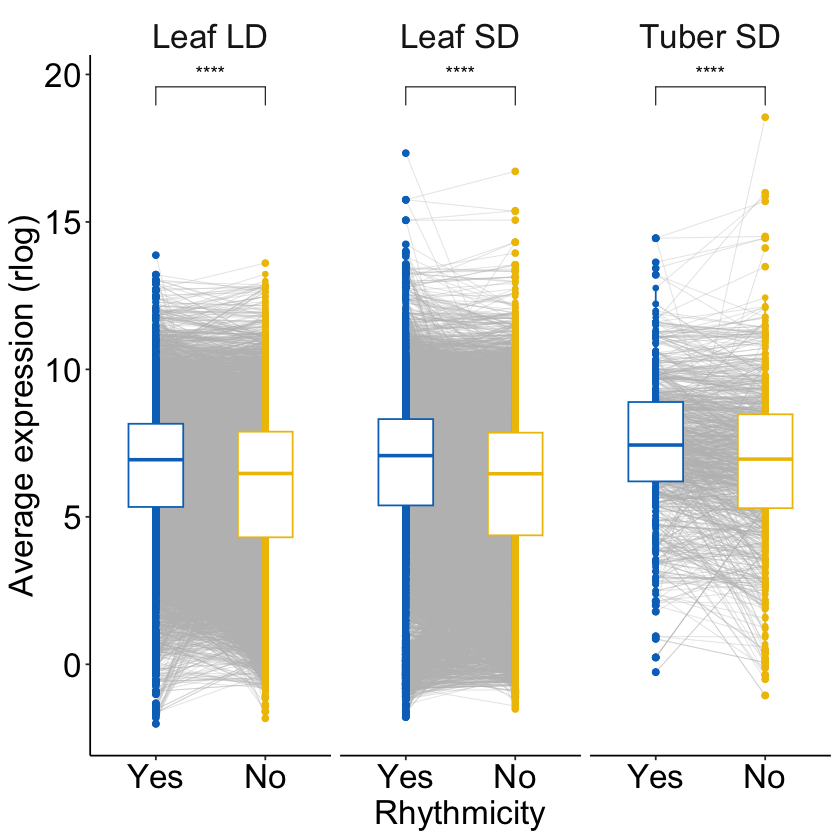

In [77]:
box<- ExpressionCycling_AllelicPairs$layers[1]
lines<- ExpressionCycling_AllelicPairs$layers[2]
points<- ExpressionCycling_AllelicPairs$layers[3]

ExpressionCycling_AllelicPairs$layers[1] <- lines
ExpressionCycling_AllelicPairs$layers[2] <- points
ExpressionCycling_AllelicPairs$layers[3] <- box
ExpressionCycling_AllelicPairs

In [78]:
## EXPORT PLOT
#::::::::::::::::::::::::::::::
ExpressionCycling_AllelicPairs%>% ggsave(file="./Results/ExpressionCycling_AllelicPairs_plot.pdf", 
                            width=7.25, height=5, dpi=600)

# Are there strong differences in phase between alleles?

In [79]:
ExprGenes[1:2,]

Syntelog,Tissue,Condition,ATL_expressed_alleles,geneID,target_id,Average,SD,ATL_alleles,BH.Q,ADJ.P,Period,Adj_phase,Amplitude
<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>
Synt_1,Leaf,LD,4,Soltu.Atl_v3.01_1G000020.2,Soltu.Atl_v3.01_1G000020,7.395377,0.1577245,4,1,1,20,19,0.10051609
Synt_1,Leaf,LD,4,Soltu.Atl_v3.01_2G000020.1,Soltu.Atl_v3.01_2G000020,5.948141,0.1212230,4,1,1,20,4,0.09175902


In [80]:
### ADJUST PHASE VALUES, SINCE PHASE = 25 NEEDS TO BE CONVERTED TO 1
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
ExprGenes<-ExprGenes %>% 
            mutate(Adj_phase2 = case_when(Adj_phase == 25 ~ 1,
                                         Adj_phase != 25 ~ Adj_phase))

In [81]:
ExprGenes[1:2,]

Syntelog,Tissue,Condition,ATL_expressed_alleles,geneID,target_id,Average,SD,ATL_alleles,BH.Q,ADJ.P,Period,Adj_phase,Amplitude,Adj_phase2
<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>
Synt_1,Leaf,LD,4,Soltu.Atl_v3.01_1G000020.2,Soltu.Atl_v3.01_1G000020,7.395377,0.1577245,4,1,1,20,19,0.10051609,19
Synt_1,Leaf,LD,4,Soltu.Atl_v3.01_2G000020.1,Soltu.Atl_v3.01_2G000020,5.948141,0.1212230,4,1,1,20,4,0.09175902,4


In [82]:
# Function to calculate phase difference:
#::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

# Note: if negative, g2 has a later phase
PhaseChange <- function(G1, G2){
            g1 <- (360*(G1/24))
            g2<- (360*(G2/24))
            delta <- g1-g2
           
            if
                (abs(delta) <= 180) { 
                angle <- delta
                dphase <- 24* angle/360
                
            }
            else  {
                angle <- 360-abs(delta)
                dphase <- (delta/abs(delta)) * 24 * angle/360
                }
            
    }

In [83]:
## CALCULATE ANALYZE PHASE DIFFERENCES LEAF
#::::::::::::::::::::::::::::::::::::::::;


GenePhaseDiff <- ExprGenes %>% filter (ADJ.P < 0.001, !is.na(Syntelog)) %>% #select only cycling alleles that are syntenic
                select(Condition,Tissue, Syntelog,target_id, Adj_phase2) %>% # select required columns
                unique()%>% #remove redundant timepoint information
                group_by(Condition, Tissue, Syntelog) %>% #group by gene to make calculations within allelic groups
                   mutate(CyclingAlleles = n()) %>% 
                ungroup () %>% group_by(Condition,Tissue, Syntelog, CyclingAlleles) %>% # you need to group by the columns you want to keep
                  filter(n() > 1)%>% # select genes with more than 1 allele
               do(data.frame(t(combn(.$target_id, 2)))) %>%
              rename(Haplotype_1 = X1, Haplotype_2 = X2) %>%
            ungroup() %>% 
             left_join(ExprGenes %>% select(Condition, Tissue, Adj_phase2,target_id) %>% unique(),relationship ='many-to-many', by = c('Condition','Tissue','Haplotype_1'= 'target_id'))%>%
             rename(Adj_phase2_1 = Adj_phase2) %>%
          left_join(ExprGenes %>% select(Condition, Tissue, Adj_phase2,target_id)%>% unique(), by = c('Condition','Tissue','Haplotype_2'= 'target_id'),relationship ='many-to-many')%>%
            rename(Adj_phase2_2 = Adj_phase2) %>% 
            ungroup() %>% 
            rowwise() %>% 
            mutate(DeltaPhase = PhaseChange(Adj_phase2_1,Adj_phase2_2))

In [84]:
GenePhaseDiff[1:2,]

Condition,Tissue,Syntelog,CyclingAlleles,Haplotype_1,Haplotype_2,Adj_phase2_1,Adj_phase2_2,DeltaPhase
<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
LD,Leaf,Synt_10002,2,Soltu.Atl_v3.04_0G000350,Soltu.Atl_v3.04_3G007490,19,19,0
LD,Leaf,Synt_10079,3,Soltu.Atl_v3.04_0G000610,Soltu.Atl_v3.04_2G006070,1,1,0


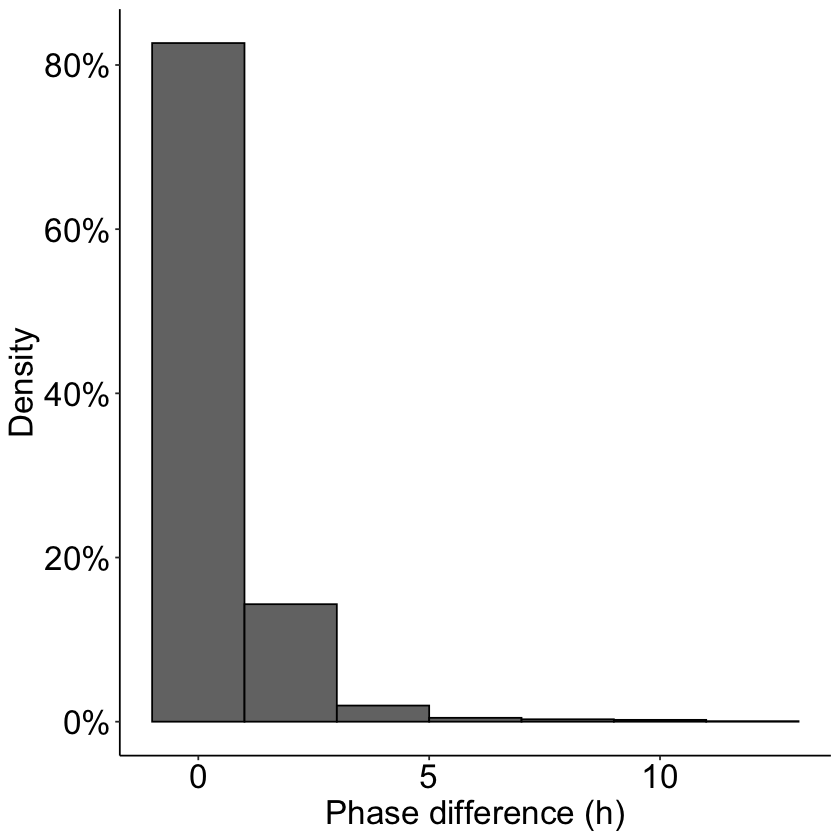

In [85]:
#Phase histogram all 3 sets of data together
#::::::::::::::::::::::::::::::::::::::::::::::::::;

PhaseDiff_hist_plot <- GenePhaseDiff %>% filter(!is.na(DeltaPhase)) %>%
                    mutate(AbsDPhase = abs(DeltaPhase)) %>%

  
              ggplot( aes(x=AbsDPhase)) +  
                

geom_histogram( aes( y = after_stat(count / sum(count))), binwidth=2, fill='#636363', color='black', alpha=0.9) +
               # scale_x_continuous(breaks = seq(0, 12, 2), lim = c(-1,12))+
                labs(y="Density", x="Phase difference (h)")+
       scale_y_continuous(labels = scales::percent)+
            
               theme_classic()+

    theme (
            axis.title.x = element_text(size = 20),
            axis.title.y = element_text(size = 20),
            axis.text = element_text(size = 20, color = "black"),
    legend.title=element_text(size=20),
                legend.text=element_text(size=20))


PhaseDiff_hist_plot

In [86]:
## EXPORT- NOT ALWAYS NEEDED
#::::::::::::::::::::::::::::::
PhaseDiff_hist_plot%>% ggsave(file="./Results/PhaseDiff_hist_plot.pdf", 
                            width=5, height=5, dpi=600)

# Which are the fully cycling genes in leaf?
Fully cycling genes are genes fully cycling in both SD and LD conditions

In [87]:
PercentCycGenes <-ExprGenes %>% select (Syntelog, geneID, target_id, ADJ.P, ATL_expressed_alleles, Condition, Tissue) %>%
            filter(!is.na(Syntelog), !is.na(ADJ.P))%>% 
            unique() %>%
            filter (ATL_expressed_alleles >=2) %>%  # select only syntelogs with at least 2 cycling alleles
            group_by(Syntelog, Condition, Tissue) %>% 
            mutate (percentCycling = sum(ADJ.P<0.001)*100/n())%>% 
            filter(percentCycling > 0) %>% ## SELECT SYNTELOGS WITH SOME CYCLING GENES
            mutate(CyclingAlleles = sum(ADJ.P<0.001),
                  NotCyclingAlleles = sum(ADJ.P>=0.001 )) %>% ungroup()
PercentCycGenes[1:5,]

Syntelog,geneID,target_id,ADJ.P,ATL_expressed_alleles,Condition,Tissue,percentCycling,CyclingAlleles,NotCyclingAlleles
<chr>,<chr>,<chr>,<dbl>,<int>,<chr>,<chr>,<dbl>,<int>,<int>
Synt_1,Soltu.Atl_v3.01_1G000020.2,Soltu.Atl_v3.01_1G000020,0.0003020109,4,SD,Leaf,25,1,3
Synt_1,Soltu.Atl_v3.01_2G000020.1,Soltu.Atl_v3.01_2G000020,1.0000000000,4,SD,Leaf,25,1,3
Synt_1,Soltu.Atl_v3.01_3G000040.1,Soltu.Atl_v3.01_3G000040,0.9997025815,4,SD,Leaf,25,1,3
Synt_1,Soltu.Atl_v3.01_4G000020.2,Soltu.Atl_v3.01_4G000020,0.0552409007,4,SD,Leaf,25,1,3
Synt_10,Soltu.Atl_v3.01_2G000110.1,Soltu.Atl_v3.01_2G000110,0.0094135014,2,SD,Leaf,50,1,1


In [88]:
# Fully Cycling Syntelogs LEAF
#:::::::::::::::::::::::::::::::::
FullyCyclingGenesLeaf <- PercentCycGenes %>% filter (percentCycling == 100, Tissue == 'Leaf')
FullyCyclingGenesLeaf[1:5.,]

FullyCyclingGenesLeaf %>% select(Syntelog, Condition) %>% group_by(Condition) %>% summarize(NumberOfGenes= n())

Syntelog,geneID,target_id,ADJ.P,ATL_expressed_alleles,Condition,Tissue,percentCycling,CyclingAlleles,NotCyclingAlleles
<chr>,<chr>,<chr>,<dbl>,<int>,<chr>,<chr>,<dbl>,<int>,<int>
Synt_10002,Soltu.Atl_v3.04_0G000350.4,Soltu.Atl_v3.04_0G000350,9.021980e-04,2,LD,Leaf,100,2,0
Synt_10002,Soltu.Atl_v3.04_3G007490.1,Soltu.Atl_v3.04_3G007490,7.966112e-04,2,LD,Leaf,100,2,0
Synt_10030,Soltu.Atl_v3.04_1G008320.5,Soltu.Atl_v3.04_1G008320,2.332606e-07,2,SD,Leaf,100,2,0
Synt_10030,Soltu.Atl_v3.04_2G005610.3,Soltu.Atl_v3.04_2G005610,6.601193e-06,2,SD,Leaf,100,2,0
Synt_10033,Soltu.Atl_v3.04_0G001170.3,Soltu.Atl_v3.04_0G001170,1.927217e-07,2,SD,Leaf,100,2,0


Condition,NumberOfGenes
<chr>,<int>
LD,5063
SD,7418


In [89]:
# Transcripts of fully cycling genes in either SD or LD
FullyCyclingGenesLeaf %>% select(Syntelog, geneID) %>% unique() %>% nrow()

[1] 9888

In [90]:
# Transcripts of fully cycling genes in SD or LD
length(intersect(FullyCyclingGenesLeaf %>% filter(Condition == 'SD') %>% pull(geneID) ,
           FullyCyclingGenesLeaf %>% filter(Condition == 'LD') %>% pull(geneID)))

[1] 2593

In [91]:

export(FullyCyclingGenesLeaf %>% select(Syntelog, geneID) %>% unique() %>% select(geneID),
       file = './Results/FullyCyclingGenesLeaf_SDorLD.csv')



export(intersect(FullyCyclingGenesLeaf %>% filter(Condition == 'SD') %>% select(geneID) ,
           FullyCyclingGenesLeaf %>% filter(Condition == 'LD') %>% select(geneID)),
       file = './Results/FullyCyclingGenesLeaf_SDandLD.csv')

### Export all cycling transcripts from genes with at least 2 expressed alleles. These transcripts will cycle in either SD OR LD

In [92]:
export( ExprGenes %>% select (Syntelog, geneID, target_id, ADJ.P, ATL_expressed_alleles, Condition, Tissue) %>%
            unique() %>%
            filter (Tissue == "Leaf", ATL_expressed_alleles >=2, ADJ.P < 0.001) %>% select(geneID) %>% unique(),
       file = './Results/CyclingGenesLeaf_SDorLD_2ormoreExprAlleles.csv')

### Export all cycling transcripts from genes with at least 2 expressed alleles. These transcripts will cycle in SD AND LD

In [93]:
SDcyc <- ExprGenes %>% select (Syntelog, geneID, target_id, ADJ.P, ATL_expressed_alleles, Condition, Tissue) %>%
            unique() %>% 
            filter (Tissue == "Leaf",Condition == 'SD', ATL_expressed_alleles >=2, ADJ.P < 0.001) %>% select(geneID) %>% unique()

LDSDcyc <- ExprGenes %>% select (Syntelog, geneID, target_id, ADJ.P, ATL_expressed_alleles, Condition, Tissue) %>%
            unique() %>% 
            filter (Tissue == "Leaf",Condition == 'LD', ATL_expressed_alleles >=2, ADJ.P < 0.001, geneID %in% SDcyc$geneID) %>% 
            select(geneID) %>% unique()


In [94]:
nrow(LDSDcyc)

[1] 5870

In [95]:
export(LDSDcyc, 
       file = './Results/CyclingGenesLeaf_SDandLD_2ormoreExprAlleles.csv')

# Functional enrichment analysis of fully cycling genes using Mercaptor


I had done the determination of Mercaptor functional terms for the ATL genome using: https://www.plabipd.de
The file is /Users/Eva/Dropbox/Potato/RNA-seq_2/MapMan/ATL.results.txt

I used the models from ATL_v3.hc_gene_models.repr.pep.fa. All the genes in our transcriptome analysis are found in our annotation results, Mercaptor tool gives you an error if genes in your selected lists do not overlap with the annotation file provided.


Cycling in SD **and** LD: \ 
Background: CyclingGenesLeaf_SDandLD_2ormoreExprAlleles.csv \
test: FullyCyclingGenesLeaf_SDandLD.csv \
Results: 20250324_FullyCyclingGenesLeaf_SDandLD_vs_CyclingGenesLeaf_SDandLD_2ormoreExprAlleles.tsv


Cycling in SD **or** LD: \
Test: FullyCyclingGenesLeaf_SDorLD.csv\
Background: CyclingGenesLeaf_SDorLD_2ormoreExprAlleles.csv\
Results: FullyCyclingGenesLeaf_SDorLDVSCyclingGenesLeaf_SDorLD_2ormoreExprAlleles

